In [39]:
import numpy as np 
import random
from scipy.optimize import minimize
from sphere_decoding.sphereDecodingUseC import sphere_decoding_BER
import matplotlib.pyplot as plt
from timeit import default_timer as time

# 交叉熵正常训练


Nt = 2
Nr = 4

iter_num = 30
channel_list = np.load("channel_list_4_2.npy")
H_list = channel_list[0:iter_num]

SNR_list = np.array([0,5,10,15,20,25])


alpha = 0.1

max_iter = 1000

pilot_length = 128

beta1 = 0

SD_mean_performance = np.zeros(len(SNR_list))
QNN_mean_performance_128 = np.zeros(len(SNR_list))

save_loss = np.empty((len(SNR_list), iter_num))
save_BER = np.empty((len(SNR_list), iter_num))
save_channel = np.empty((len(SNR_list), iter_num, Nr, Nt), dtype=np.complex128)

In [40]:
# generate signals for simulation
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = [np.array([qam16_modulation(bits_sequence[i+j]) for j in range(Nt)]) for i in range(0, len(bits_sequence), Nt)]
    return bits_sequence, x_sequence

def generate_noise(SNR, Nr):
    return np.sqrt(1/(2*SNR))*(np.random.randn(Nr,1)+1j*np.random.randn(Nr,1))

def generate_data(Nr,Nt,SNR_dB,length,H_channel):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    SNR= 10**(SNR_dB/10)
    n_sequence = [generate_noise(SNR, Nr) for i in range(length)]
    y_sequence = [(np.dot(H_channel, x_sequence[i].reshape(Nt,1)) + n_sequence[i])*np.sqrt(1) for i in range(length)]
    return bits_sequence, x_sequence, y_sequence



# training H_hat

def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)

def calculate_layer1_training(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    output = np.empty(dimension_layer1)
    # calculate gradient components in layer1
    gradients = np.zeros((dimension_layer1, Nr, Nt), dtype=np.complex128)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        # s_conjugate_transpose = s.conj().T
        error = y - np.dot(H_hat,s)
        value =  np.exp(-np.square(np.linalg.norm(error)))
        output[index] = value
        gradient_component = np.dot(error, s.conj().T)
        gradients[index] = -value*(-gradient_component)
    return output, gradients

def layer2_matrix(n):
    if n == 1:
        return np.array([0,1])
    else:
        last_ = layer2_matrix(n-1)
        half_cols_num = 2**(n-1)
        first_row = np.concatenate((np.zeros(half_cols_num), np.ones(half_cols_num)))
        remain_rows = np.hstack((last_, last_))
        # print(remain_rows)
        return np.vstack((first_row, remain_rows))


def calculate_layer2_training(layer1_output, true_output):
    total_prob = np.sum(layer1_output)
    # print(total_prob)
    A = layer2_matrix(4*Nt)
    sum_prob_1 = np.dot(A, layer1_output)
    # layer2 output
    output = np.array([sum_prob_1[ii]/total_prob for ii in range(4*Nt)])
    # calculate gradient components in layer2
    gradients = np.zeros(2**(4*Nt))
    for ii in range(len(gradients)):
        for jj in range(4*Nt):
            gradients[ii] += (-1/(4*Nt))*((true_output[jj]/output[jj])-((1-true_output[jj])/(1-output[jj])))*((A[jj][ii]/total_prob)-(sum_prob_1[jj]/np.square(total_prob)))
    return output, gradients


# def calculate_square_error(layer2_output, true_sequence):
#     return np.linalg.norm(layer2_output-true_sequence)**2

def calculate_cross_entropy(layer2_output, true_sequence):
    epsilon = 1e-30  # 为了防止log(0)的情况，添加一个小的常数
    layer2_output = np.clip(layer2_output, epsilon, 1. - epsilon)
    cross_entropy = -np.mean(true_sequence * np.log(layer2_output) + (1 - true_sequence) * np.log(1 - layer2_output))
    return cross_entropy


def calculate_cost_function(H_hat):
    total_loss = 0
    total_gradients = np.zeros((Nr,Nt), dtype=np.complex128)
    training_length = len(y_sequence)
    for ii in range(training_length):
        # print(ii)
        true_sequence = ''.join(bits_sequence[ii*Nt+jj] for jj in range(Nt))
        true_sequence = np.array([eval(ii) for ii in true_sequence])
        layer1_output, layer1_gradients = calculate_layer1_training(H_hat, y_sequence[ii])
        layer2_output, layer2_gradients = calculate_layer2_training(layer1_output, true_sequence)
        total_loss += calculate_cross_entropy(layer2_output,true_sequence)
        # SGD
        if np.random.rand() < 0.9:
            for jj in range(2**(4*Nt)):
                total_gradients += (layer2_gradients[jj]*layer1_gradients[jj])
    mean_loss = total_loss/training_length
    return mean_loss, total_gradients


def training(max_iter):
    # H_hat = np.sqrt(1/2)*(np.random.randn(Nr,Nt)+1j*np.random.randn(Nr,Nt))
    H_hat = np.zeros((Nr,Nt), dtype=np.complex128)
    # H_hat = np.copy(H)
    momentum = np.zeros((Nr,Nt),dtype=np.complex128)
    last_loss = -100
    mean_loss = -200
    for iter_num in range(max_iter):
        # solve the gradient
        mean_loss, total_gradients = calculate_cost_function(H_hat)
        print("loss: "+str(mean_loss))
        if iter_num % 10 == 9:
            # print("loss: "+str(mean_loss))
            if np.abs(last_loss-mean_loss) < 0.001:
                return H_hat, mean_loss
            else:
                last_loss = mean_loss
        # update H_hat
        momentum = (1-beta1)*total_gradients + beta1*momentum
        H_hat -= alpha * momentum
        # print(H_hat)
    return H_hat, mean_loss



# testing QNN for detection
def calculate_layer1_testing(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    output = np.zeros(dimension_layer1)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        s_conjugate_transpose = s.conj().T
        error = y - np.dot(H_hat,s)
        value =  np.exp(-np.square(np.linalg.norm(error)))
        output[index] = value
    return output

def calculate_layer2_testing(layer1_output):
    total_prob = np.sum(layer1_output)
    A = layer2_matrix(4*Nt)
    sum_prob_1 = np.dot(A, layer1_output)
    # layer2 output
    output = np.array([sum_prob_1[ii]/total_prob for ii in range(4*Nt)])
    return output

def detection(y, H_trained):
    layer1_output = calculate_layer1_testing(H_trained, y)
    layer2_output = calculate_layer2_testing(layer1_output)
    detect_result = ''
    for ii in range(len(layer2_output)):
        if(layer2_output[ii]>0.5):
            detect_result += '1'
        else:
            detect_result += '0'
    return(detect_result)

def count_differences(str1, str2):
    return sum(a != b for a, b in zip(str1, str2))

def calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing):
    error = 0
    for ii in range(len(y_sequence_testing)):
        detect_result = detection(y_sequence_testing[ii], H_trained)
        true_sequence = ''.join(bits_sequence_testing[ii*Nt+jj] for jj in range(Nt))
        error += count_differences(detect_result, true_sequence)
    BER = error/(len(y_sequence_testing)*len(detect_result))
    return BER

In [41]:
for ii in range(len(SNR_list)):
    SNR_dB = SNR_list[ii]
    
    SD_performance = np.zeros(iter_num)
    QNN_performance_128 = np.zeros(iter_num)

    for jj in range(iter_num):
        print("----------------------------current SNR_dB: " +str(SNR_dB))
        print("----------------------------current iter num: " +str(jj))

        H = H_list[jj]

        bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,SNR_dB,1024,H)
        SD_performance[jj] = sphere_decoding_BER(H, y_sequence_testing, bits_sequence_testing, 1)
        print("SD: "+str(SD_performance[jj]))

        bits_sequence, x_sequence, y_sequence = generate_data(Nr,Nt,SNR_dB,pilot_length,H)
        H_trained, loss = training(max_iter)

        save_channel[ii][jj] = H_trained
        save_loss[ii][jj] = loss
        
        BER = calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing)

        save_BER[ii][jj] = BER

        QNN_performance_128[jj] = BER
        print("QNN: "+str(BER))

    SD_mean_performance[ii] = np.mean(SD_performance)
    QNN_mean_performance_128[ii] = np.mean(QNN_performance_128)

----------------------------current SNR_dB: 0
----------------------------current iter num: 0
SD: 0.05322265625
loss: 0.6931471805599463
loss: 0.34277437301345187
loss: 0.31147433326678975
loss: 0.3042542236395964
loss: 0.303029202340625
loss: 0.301759354567989
loss: 0.30256451317085054
loss: 0.30218209064350304
loss: 0.3014067864351765
loss: 0.3026021518182395
loss: 0.3021390974977398
loss: 0.302663440962646
loss: 0.301636584169918
loss: 0.30184642871944944
loss: 0.30282135078126593
loss: 0.3056834163534567
loss: 0.3021496763609939
loss: 0.3021178438347461
loss: 0.3037346910835884
loss: 0.30274556984637985
QNN: 0.1444091796875
----------------------------current SNR_dB: 0
----------------------------current iter num: 1
SD: 0.1053466796875
loss: 0.6931471805599463
loss: 0.3791780724425253
loss: 0.3605477672427865
loss: 0.3565359849583167
loss: 0.3557980978780517
loss: 0.35575552581285397
loss: 0.3552207913560648
loss: 0.35584303381630167
loss: 0.3558663686122898
loss: 0.356103656299513

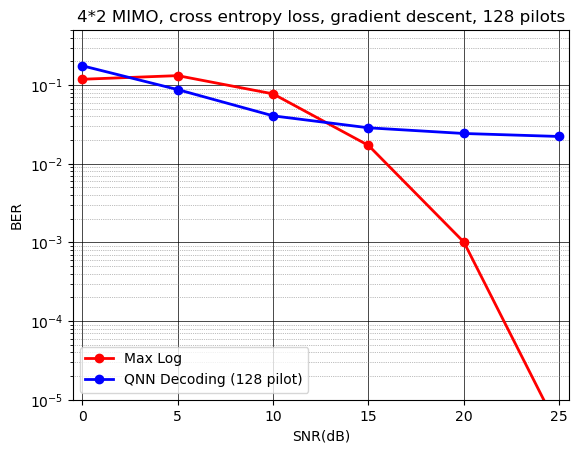

In [42]:
import matplotlib.ticker as ticker
fig = plt.figure()

ax1 = fig.add_subplot(111)

lns1 = ax1.plot(SNR_list, SD_mean_performance, '-ro', linewidth=2.0, label="Max Log")
lns2 = ax1.plot(SNR_list, QNN_mean_performance_128, '-bo', linewidth=2.0, label="QNN Decoding (128 pilot)")



lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto'))
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

ax1.set_xticks(SNR_list)
ax1.set_yscale("log")
ax1.set_adjustable("datalim")
ax1.set_xlim(-0.5,25.5)
ax1.set_ylim(1e-5, 0.5)
ax1.set_ylabel("BER")
ax1.set_xlabel("SNR(dB)")
plt.title("4*2 MIMO, cross entropy loss, gradient descent, 128 pilots")

plt.savefig('BER.png',dpi=600, bbox_inches='tight')
plt.show()

In [37]:
save_channel[0][0]

array([[-0.42285545+0.62606458j, -0.84648585-1.90772263j],
       [-0.87646608+0.83763628j, -1.37942579+0.91253003j],
       [ 0.57674952+0.97768131j,  0.50516082-0.45890055j],
       [-0.27671069+0.05670283j,  0.13824529+1.48844958j]])

In [38]:
H_list[0]

array([[-0.37533806+0.49157468j, -0.79734719-1.74176951j],
       [-0.71785279+0.70506569j, -1.2926474 +0.82855668j],
       [ 0.46385573+0.77768565j,  0.44475096-0.39933949j],
       [-0.19958736+0.06235297j,  0.12763225+1.35868458j]])